In [1]:
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, ConcatDataset, Subset
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.ops import DropBlock2d
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
import pathlib
from PIL import Image


In [4]:
class augmented_dataset(Dataset):
    def __init__(self, targ_dir):
        self.paths = list(pathlib.Path(targ_dir).glob("*.jpg"))
        self.classes = ['Correct']
        self.class_to_idx = {'Classes':0}
        self.data = [(img, 'augm1') for img in self.paths]
        self.data.extend([(img, 'augm2') for img in self.paths])
        self.data.extend([(img, 'augm3') for img in self.paths])
        self.transform1 = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.ColorJitter(1),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

        ])
        self.transform2 = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(1),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

        ])
        self.transform3 = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.RandomRotation(1),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

        ])
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):

        if self.data[i][1] == 'augm1':
            img = Image.open(self.data[i][0])
            img = self.transform1(img)

        if self.data[i][1] == 'augm2':
            img = Image.open(self.data[i][0])
            img = self.transform2(img)

        if self.data[i][1] == 'augm3':
            img = Image.open(self.data[i][0])
            img = self.transform3(img)              

        return img,0

#train and test data directory
data_dir = "PetImages/RevisitedTraining"
correct_label_dir = "PetImages/RevisitedTraining/Correct"

dataset = ImageFolder(data_dir, transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

aug_set = augmented_dataset(correct_label_dir)
# print("OOga",len(aug_set))
item1, lab1 = aug_set[0]
# print(item1)

# print("Classes", (dataset.class_to_idx), (dataset.classes))
# print("Dataset len",len(dataset))
t1, l1 = dataset[0]
# print(t1)

concat_dataset = ConcatDataset([dataset, aug_set])
# print(len(concat_dataset))


#Manually inputting correct proportions of values
n = 1000
# indices1 = torch.randperm(len(aug_set))[:size-1000]
indices1 = torch.randperm(len(aug_set))[:n]
indices2 = torch.randperm(len(dataset))[:n]
part1_subset = Subset(aug_set, indices1)
part2_subset = Subset(dataset,indices2)
print("Aug set", len(part1_subset))
print("Norm set", len(part2_subset))
new_subset = ConcatDataset([part1_subset,part2_subset])
# n = len(new_subset)
print("New subset length",n)
n_train = int(0.8 * len(new_subset))
train, test = random_split(new_subset, [n_train, len(new_subset)-n_train])
print(len(train), "train")
print(len(test), "test")

#Processing code
# testn = len(concat_dataset)
# testn_train = 1000
# train1, test1 = random_split(concat_dataset, [testn_train, testn-testn_train])
# print(len(train1))

# n = len(train1)
# n_train = int(0.7 * n)
# train, test = random_split(train1, [n_train, n-n_train])

#Loading training and testing set into batches
train_dl = DataLoader(train, batch_size=128, num_workers=0, shuffle=True)
test_dl = DataLoader(test, batch_size=128, num_workers=0, shuffle=False)



Aug set 1000
Norm set 1000
New subset length 1000
1600 train
400 test


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


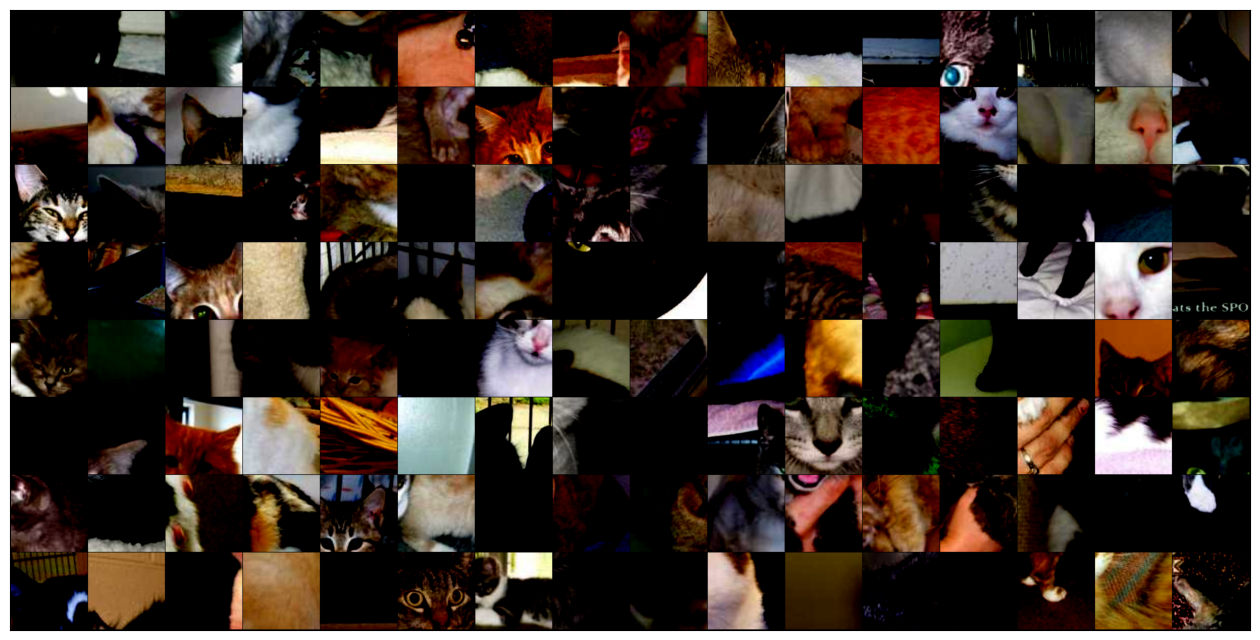

In [8]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [5]:
class CNN(nn.Module):
    #https://www.kaggle.com/code/androbomb/using-cnn-to-classify-images-w-pytorch
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.batchnorm1 = nn.BatchNorm2d(12)

        self.batchnorm2 = nn.BatchNorm2d(24)

        self.drop = DropBlock2d(p=0.2, block_size=9)   

        # self.fc1 = nn.Linear(16*5*5,120)

        # self.fc2 = nn.Linear(120,84)

        # self.fc3 = nn.Linear(84,10)

        self.fc = nn.Linear(in_features=24 * 64 * 64, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))

        # x = self.batchnorm1(x)
        # x = F.dropout(self.drop(x), training=self.training)

        x = F.relu(self.pool(self.conv2(x)))
        # x = F.dropout(self.drop(x), training=self.training)

        # x = self.batchnorm2(x)
        
        # x = F.dropout(self.drop(x), training=self.training)

        x = x.view(-1, 24 * 64 * 64)
        x = self.fc(x)

        # x = torch.flatten(x,1)
        # x = self.fc1(x)
        # x = self.fc2(x)
        # x = self.fc3(x)

        # Sigmoid pref because binary output
        # return torch.sigmoid(x)
        return torch.log_softmax(x, dim=1)

device = "cpu"
if (torch.cuda.is_available()):
    device = "cuda"

model = CNN(num_classes=2).to(device)
print(model)

def train(model, device, train_loader, optimizer, epoch):
    # Set the model to train
    model.train()
    train_loss = 0
    correct = 0
    print("Epoch: ", epoch)

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        correct += torch.sum(target == predicted).item()

        print("\tTraining batch {} Loss: {:.6f}".format(batch_idx + 1, loss.item()))

    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f})\n'.format(avg_loss, correct, len(train_loader.dataset), 100. * correct / len(train_loader.dataset)))

    return avg_loss, 100. * correct / len(train_loader.dataset)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            output = model(data)

            test_loss += loss_criteria(output, target).item()

            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target == predicted).item()

    
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f})\n'.format(avg_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

    return avg_loss, 100. * correct / len(test_loader.dataset)


optimizer = optim.Adam(model.parameters(), lr=0.0001)

loss_criteria = nn.CrossEntropyLoss()

epoch_nums = []
training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []

epochs = 5
print("Training on", device)
for epoch in range (1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_dl, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_dl)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)
    training_accuracy.append(train_accuracy)
    validation_accuracy.append(test_accuracy)

    

CNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): DropBlock2d(p=0.2, block_size=9, inplace=False)
  (fc): Linear(in_features=98304, out_features=2, bias=True)
)
Training on cuda
Epoch:  1
	Training batch 1 Loss: 0.692846
	Training batch 2 Loss: 0.677418
	Training batch 3 Loss: 0.705431
	Training batch 4 Loss: 0.691605
	Training batch 5 Loss: 0.673126
	Training batch 6 Loss: 0.696919
	Training batch 7 Loss: 0.691380
	Training batch 8 Loss: 0.693672
	Training batch 9 Loss: 0.682603
	Training batch 10 Loss: 0.690872
	Training batch 11 Loss: 0.686719
	Training batch 12 Loss: 0.688348
	Training batch 13

Getting predictions from test set…


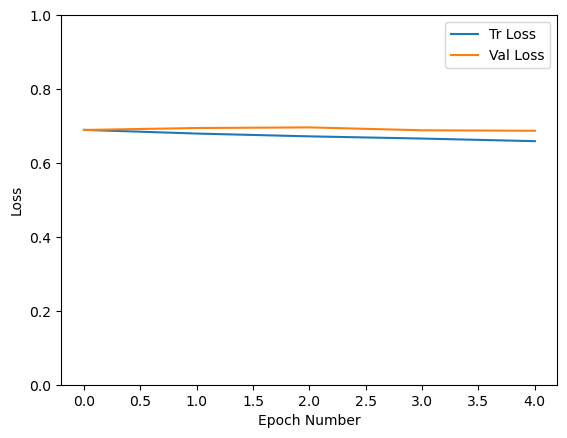

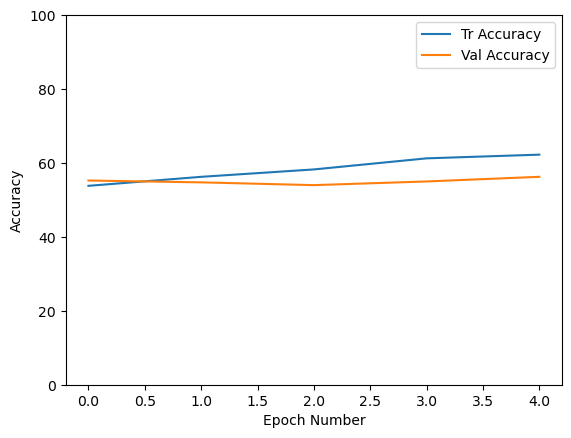

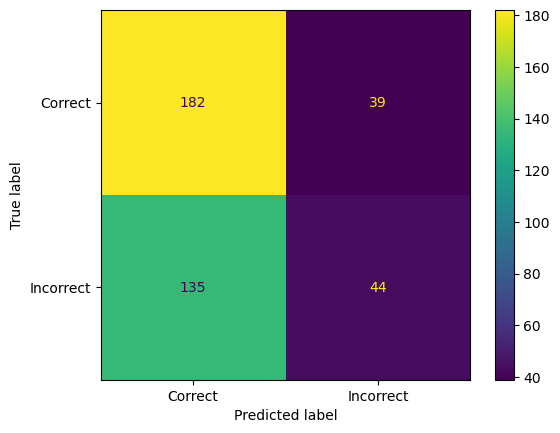

F1 Score:
0.6765799256505576


In [6]:
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set…")
for data, target in test_dl:
    data = data.to(device)
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model(data):
        predictions.append(torch.argmax(prediction).item())


plt.plot(training_loss)
plt.plot(validation_loss)
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
# plt.savefig(dataset+'_loss_curve.png')
plt.show()

# Display accuracy over training
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,100)
# plt.savefig(dataset+'_accuracy_curve.png')
plt.show()


# Plot the confusion matrix
labels = ["Correct", "Incorrect"]
cm = confusion_matrix(truelabels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print("F1 Score:")
f1 = f1_score(truelabels, predictions, pos_label=0,average='binary')
print(f1)
# Block size 9 - 0.40153452685423


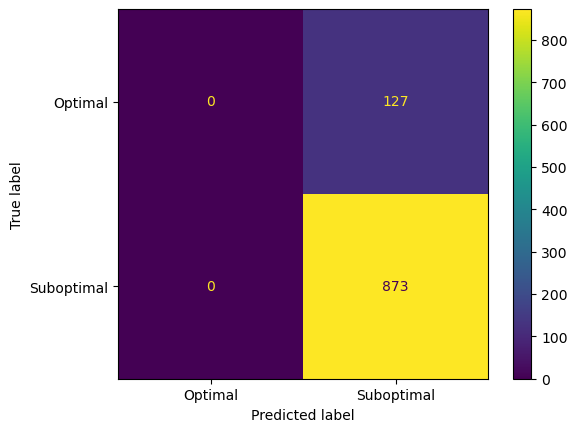

In [16]:
actual = []
predicted = []
display_labels = ["Optimal", "Suboptimal"]
for i in range(0,1000):
    predicted.append(1)
    if i < 127:
        actual.append(0)
    else:
        actual.append(1)

cm = confusion_matrix(actual, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot()
plt.show()